In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay, roc_curve, ConfusionMatrixDisplay
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)


In [2]:
demographic_df = pd.read_csv('SHED_cleaned_all_borrowers.csv', low_memory=False)
demographic_df.head(2)

,Student Loan,Amt Owed,Delinquent,Age Category,Household Income,Education,Race,Gender,Year
0,Yes,"$5,000 to $9,999",No,45-54,"$100,000 to $149,999",Bachelor's degree or higher,"White, Non-Hispanic",Male,2024
1,Yes,"$100,000 or above",Yes,45-54,"$150,000 or more",Bachelor's degree or higher,"White, Non-Hispanic",Female,2024


In [3]:
demographic_df["Year"] = demographic_df["Year"].astype(str).str.strip()

In [4]:
pre_cares = demographic_df[demographic_df["Year"].astype(int) <= 2019].copy()
post_resumption = demographic_df[demographic_df["Year"] == "2024"].copy()

In [5]:
from sklearn.preprocessing import OneHotEncoder

def preprocess(df):
    df = df.copy()
    df["Delinquent"] = df["Delinquent"].astype(str).str.strip().str.title()
    df = df[df["Delinquent"].isin(["Yes", "No"])]
    df["Delinquent"] = df["Delinquent"].map({"Yes": 1, "No": 0})
    
    y = df["Delinquent"]
    X = df[["Gender", "Race", "Education", "Household Income", "Age Category"]]
    
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_encoded = encoder.fit_transform(X)
    feature_names = encoder.get_feature_names_out(X.columns)
    
    return pd.DataFrame(X_encoded, columns=feature_names), y
    
X_pre, y_pre = preprocess(pre_cares)
X_post, y_post = preprocess(post_resumption)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model_pre = LogisticRegression(max_iter=1000)
model_pre.fit(X_pre, y_pre)

model_post = LogisticRegression(max_iter=1000)
model_post.fit(X_post, y_post)

LogisticRegression(max_iter=1000)

In [7]:
coeff_pre = pd.Series(model_pre.coef_[0], index=X_pre.columns)
coeff_post = pd.Series(model_post.coef_[0], index=X_post.columns)

comparison = pd.DataFrame({
    "Pre-CARES Coeff": coeff_pre,
    "Post-Resumption Coeff": coeff_post
}).sort_values(by="Post-Resumption Coeff", ascending=False)

In [8]:
comparison

,Pre-CARES Coeff,Post-Resumption Coeff
Education_High school graduate (high school diploma or the equivalent GED),NaN,1.128281
Education_No high school diploma or GED,NaN,1.059667
Age Category_55-64,1.229566,0.869857
Age Category_45-54,1.501474,0.759197
Education_Some college or Associate's degree,NaN,0.754621
Age Category_35-44,1.205271,0.602883
Age Category_75+,0.563213,0.538405
"Household Income_Less than $10,000",NaN,0.355991
Age Category_65-74,0.584347,0.340314
Age Category_25-34,0.946371,0.200787


In [9]:
comparison["Delta"] = comparison["Post-Resumption Coeff"] - comparison["Pre-CARES Coeff"]
comparison.sort_values("Delta", ascending=False).head(10)

,Pre-CARES Coeff,Post-Resumption Coeff,Delta
"Race_Other, Non-Hispanic",-0.395135,0.044338,0.439473
Race_Hispanic,0.071440,0.133090,0.061650
Gender_Male,0.101502,0.163068,0.061566
Age Category_75+,0.563213,0.538405,-0.024808
"Race_White, Non-Hispanic",-0.412000,-0.543368,-0.131368
"Race_Black, Non-Hispanic",0.109622,-0.130320,-0.239942
Age Category_65-74,0.584347,0.340314,-0.244033
Age Category_55-64,1.229566,0.869857,-0.359710
Age Category_35-44,1.205271,0.602883,-0.602388
Age Category_45-54,1.501474,0.759197,-0.742278


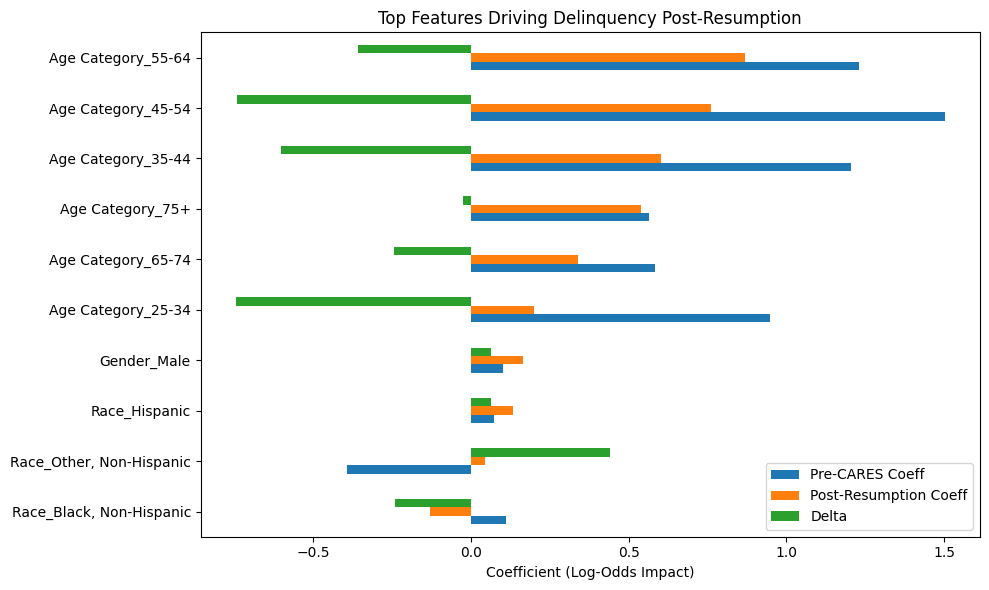

In [10]:
comparison.dropna().sort_values("Post-Resumption Coeff", ascending=True).tail(10).plot(kind='barh', figsize=(10, 6))
plt.title("Top Features Driving Delinquency Post-Resumption")
plt.xlabel("Coefficient (Log-Odds Impact)")
plt.tight_layout()
plt.show()

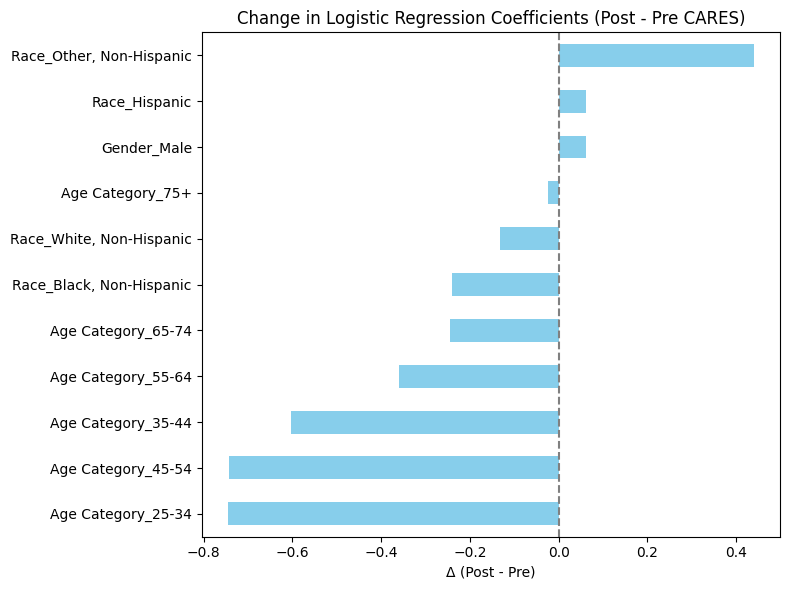

In [11]:
comparison["Delta"].dropna().sort_values().plot(kind='barh', figsize=(8, 6), color='skyblue')
plt.axvline(0, color='gray', linestyle='--')
plt.title("Change in Logistic Regression Coefficients (Post - Pre CARES)")
plt.xlabel("Δ (Post - Pre)")
plt.tight_layout()
plt.show()

In [12]:
def preprocess_combined(df):
    df = df.copy()
    df["Delinquent"] = df["Delinquent"].astype(str).str.strip().str.title()
    df = df[df["Delinquent"].isin(["Yes", "No"])]
    df["Delinquent"] = df["Delinquent"].map({"Yes": 1, "No": 0})
    
    df["Year"] = df["Year"].astype(str).str.strip()
    
    X = df[["Gender", "Race", "Education", "Household Income", "Age Category", "Year"]]
    y = df["Delinquent"]

    encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_encoded = encoder.fit_transform(X)
    feature_names = encoder.get_feature_names_out(X.columns)

    return pd.DataFrame(X_encoded, columns=feature_names), y, encoder

In [13]:
X_all, y_all, encoder_all = preprocess_combined(demographic_df)

from sklearn.linear_model import LogisticRegression

model_all = LogisticRegression(max_iter=1000)
model_all.fit(X_all, y_all)

coeff_all = pd.Series(model_all.coef_[0], index=X_all.columns)

In [14]:
X_pre, y_pre = preprocess(pre_cares)
X_post, y_post = preprocess(post_resumption)

model_pre = LogisticRegression(max_iter=1000).fit(X_pre, y_pre)
model_post = LogisticRegression(max_iter=1000).fit(X_post, y_post)

coeff_pre = pd.Series(model_pre.coef_[0], index=X_pre.columns)
coeff_post = pd.Series(model_post.coef_[0], index=X_post.columns)

In [15]:
comparison = pd.DataFrame({
    "Combined Model Coeff": coeff_all,
    "Pre-CARES Coeff": coeff_pre,
    "Post-Resumption Coeff": coeff_post
})

comparison["Delta (Post - Pre)"] = comparison["Post-Resumption Coeff"] - comparison["Pre-CARES Coeff"]
comparison["Delta (Combined - Pre)"] = comparison["Combined Model Coeff"] - comparison["Pre-CARES Coeff"]
comparison["Delta (Combined - Post)"] = comparison["Combined Model Coeff"] - comparison["Post-Resumption Coeff"]

comparison = comparison.sort_values("Combined Model Coeff", ascending=False)

In [16]:
comparison

,Combined Model Coeff,Pre-CARES Coeff,Post-Resumption Coeff,Delta (Post - Pre),Delta (Combined - Pre),Delta (Combined - Post)
Age Category_45-54,1.532706,1.501474,0.759197,-0.742278,0.031231,0.773509
Education_Less than high school,1.439188,1.418622,NaN,NaN,0.020566,NaN
Age Category_55-64,1.394604,1.229566,0.869857,-0.359710,0.165038,0.524747
Education_No high school diploma or GED,1.364874,NaN,1.059667,NaN,NaN,0.305207
Education_High school graduate (high school diploma or the equivalent GED),1.337111,NaN,1.128281,NaN,NaN,0.208830
Age Category_35-44,1.292790,1.205271,0.602883,-0.602388,0.087519,0.689907
Education_High school,1.223428,1.286167,NaN,NaN,-0.062739,NaN
Education_Some college or Associate's degree,1.019208,NaN,0.754621,NaN,NaN,0.264587
Education_Some college,0.995388,0.941793,NaN,NaN,0.053595,NaN
Age Category_25-34,0.944717,0.946371,0.200787,-0.745584,-0.001654,0.743931


In [17]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, random_state=42)

# Train
model_pred = LogisticRegression(max_iter=1000)
model_pred.fit(X_train, y_train)

# Predict
y_pred = model_pred.predict(X_test)
y_proba = model_pred.predict_proba(X_test)[:, 1]

# Evaluate
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      3673
           1       0.50      0.13      0.21       802

    accuracy                           0.82      4475
   macro avg       0.67      0.55      0.55      4475
weighted avg       0.78      0.82      0.78      4475

ROC AUC: 0.7674892879426808


# Addressed class imbalance with resampling

In [18]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_all, y_all)

model_balanced = LogisticRegression(max_iter=1000)
model_balanced.fit(X_res, y_res)

# Re-evaluate with test set
y_pred_bal = model_balanced.predict(X_test)
print(classification_report(y_test, y_pred_bal))
print("ROC AUC:", roc_auc_score(y_test, model_balanced.predict_proba(X_test)[:, 1]))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81      3673
           1       0.36      0.70      0.48       802

    accuracy                           0.72      4475
   macro avg       0.64      0.71      0.64      4475
weighted avg       0.82      0.72      0.75      4475

ROC AUC: 0.7754539936572944


In [19]:
def evaluate_model(X, y, label):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_proba)

    print(f"\n{label} Model Evaluation")
    print(f"Accuracy:  {model.score(X_test, y_test):.4f}")
    print(f"Precision: {report['1']['precision']:.4f}")
    print(f"Recall:    {report['1']['recall']:.4f}")
    print(f"F1 Score:  {report['1']['f1-score']:.4f}")
    print(f"ROC AUC:   {auc:.4f}")

# Run evaluations
evaluate_model(X_pre, y_pre, "Pre-CARES")
evaluate_model(X_post, y_post, "Post-Resumption")


Pre-CARES Model Evaluation
Accuracy:  0.8028
Precision: 0.5610
Recall:    0.1955
F1 Score:  0.2899
ROC AUC:   0.7482

Post-Resumption Model Evaluation
Accuracy:  0.8011
Precision: 0.5000
Recall:    0.1233
F1 Score:  0.1978
ROC AUC:   0.6997


In [20]:
# Train all three models again to get valid ROC predictions
model_pre = LogisticRegression(max_iter=1000).fit(X_pre, y_pre)
model_post = LogisticRegression(max_iter=1000).fit(X_post, y_post)
model_all = LogisticRegression(max_iter=1000).fit(X_all, y_all)

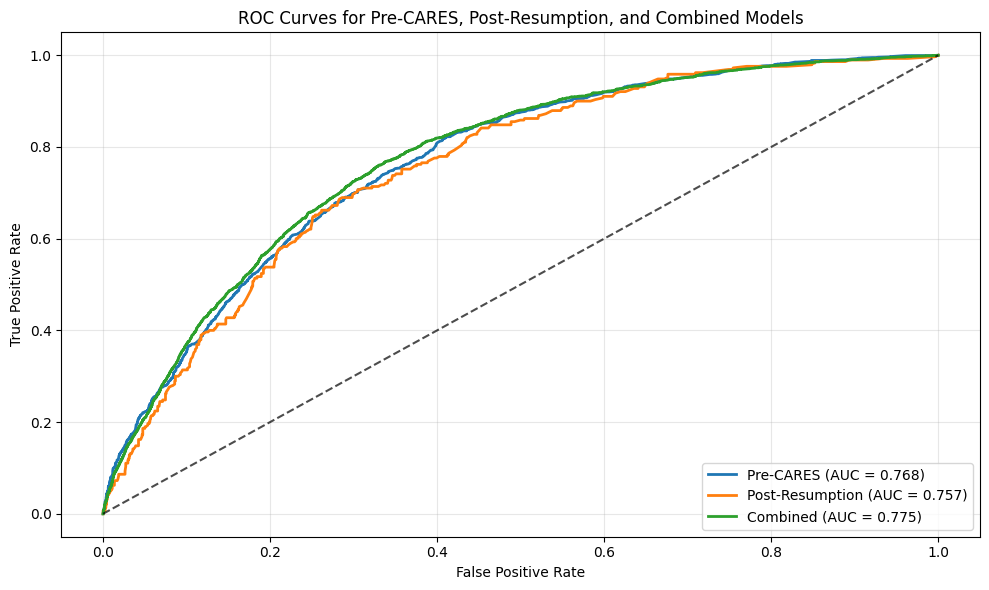

In [21]:
# Get predicted probabilities
y_pre_proba = model_pre.predict_proba(X_pre)[:, 1]
y_post_proba = model_post.predict_proba(X_post)[:, 1]
y_all_proba = model_all.predict_proba(X_all)[:, 1]

# Compute ROC curves
fpr_pre, tpr_pre, _ = roc_curve(y_pre, y_pre_proba)
fpr_post, tpr_post, _ = roc_curve(y_post, y_post_proba)
fpr_all, tpr_all, _ = roc_curve(y_all, y_all_proba)

# Compute AUC scores (optional to verify again)
auc_pre = roc_auc_score(y_pre, y_pre_proba)
auc_post = roc_auc_score(y_post, y_post_proba)
auc_all = roc_auc_score(y_all, y_all_proba)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(fpr_pre, tpr_pre, label=f'Pre-CARES (AUC = {auc_pre:.3f})', linewidth=2)
plt.plot(fpr_post, tpr_post, label=f'Post-Resumption (AUC = {auc_post:.3f})', linewidth=2)
plt.plot(fpr_all, tpr_all, label=f'Combined (AUC = {auc_all:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.7)  # Random chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Pre-CARES, Post-Resumption, and Combined Models')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

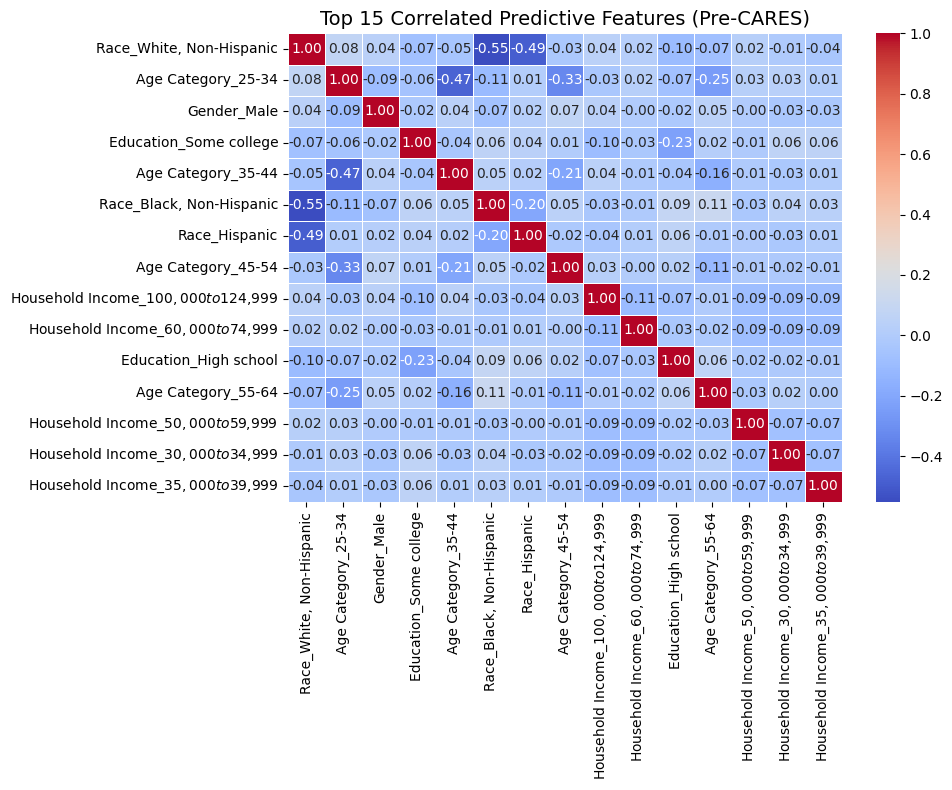

In [22]:
# Calculate standard deviation of each feature and sort
stds = pd.DataFrame(X_pre).std().sort_values(ascending=False)

# Select top N variable features
top_n = 15  # Adjust as needed
top_features = stds.head(top_n).index
X_top = pd.DataFrame(X_pre)[top_features]

# Generate simplified heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X_top.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title(f'Top {top_n} Correlated Predictive Features (Pre-CARES)', fontsize=14)
plt.tight_layout()
plt.show()

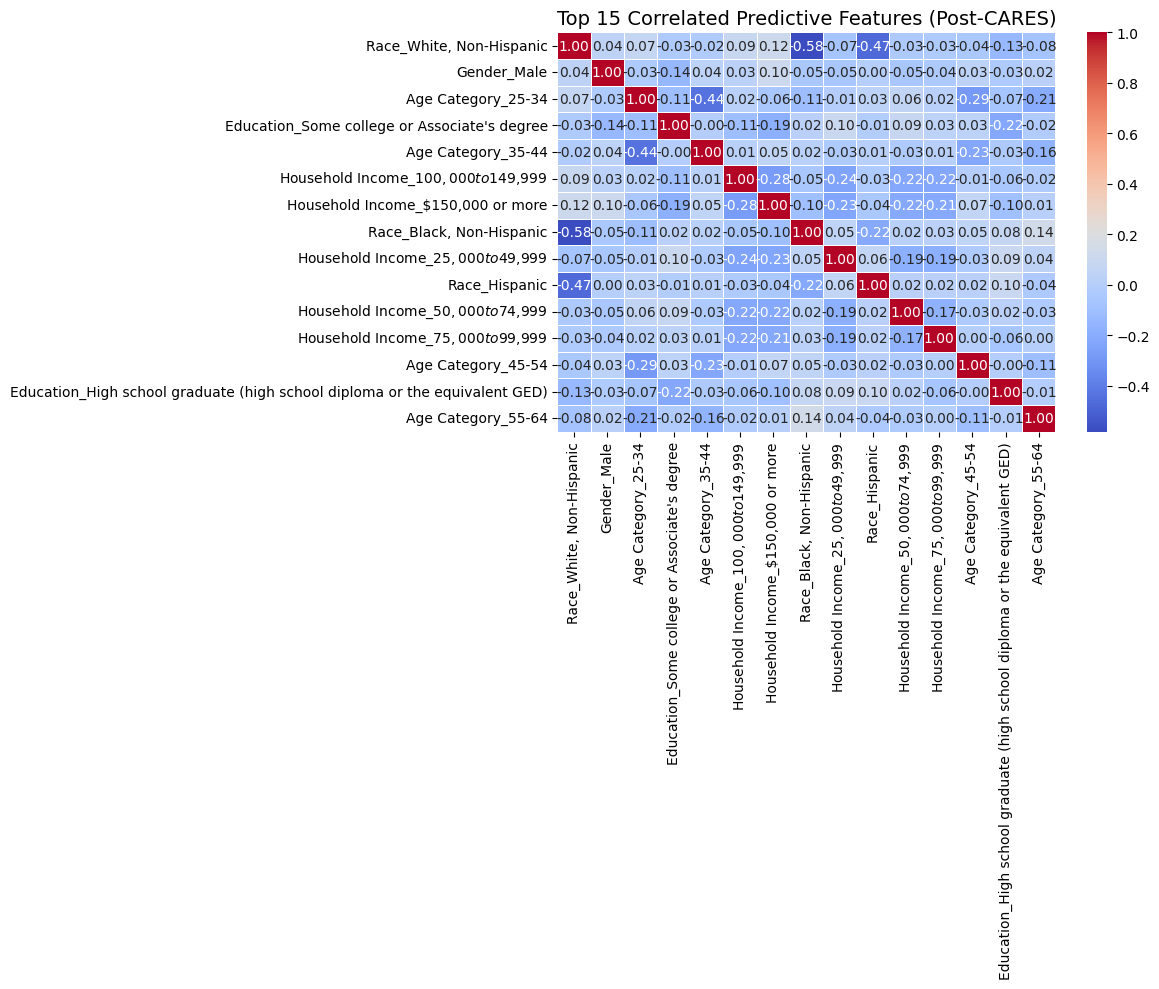

In [23]:
# Select top N most variable features in post-CARES dataset
stds_post = pd.DataFrame(X_post).std().sort_values(ascending=False)
top_n = 15  # Adjust this if you want more/less detail
top_features_post = stds_post.head(top_n).index
X_top_post = pd.DataFrame(X_post)[top_features_post]

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(X_top_post.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title(f'Top {top_n} Correlated Predictive Features (Post-CARES)', fontsize=14)
plt.tight_layout()
plt.show()

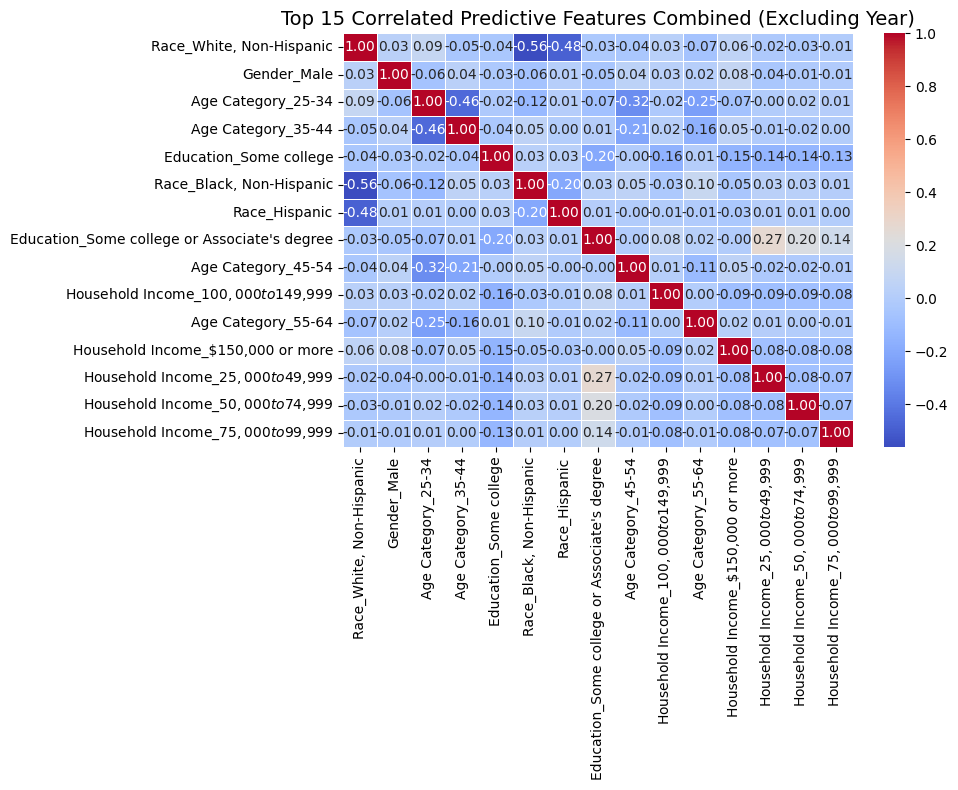

In [24]:
# Remove columns that start with "Year_" before calculating correlations
year_cols = [col for col in X_all.columns if col.startswith("Year_")]
X_all_no_year = X_all.drop(columns=year_cols)

# Then proceed with top N standard deviation logic
stds = pd.DataFrame(X_all_no_year).std().sort_values(ascending=False)
top_features = stds.head(15).index
X_top = pd.DataFrame(X_all_no_year)[top_features]

# Plot the cleaner heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(X_top.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title(f'Top 15 Correlated Predictive Features Combined (Excluding Year)', fontsize=14)
plt.tight_layout()
plt.show()

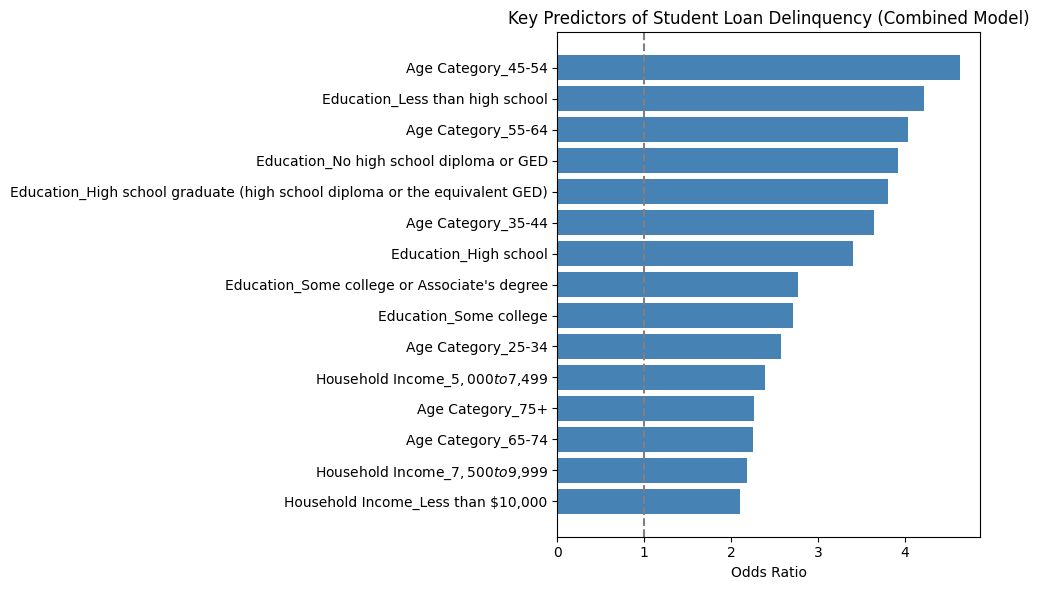

In [25]:
# Get feature names and model coefficients
feature_names = X_all.columns  # Assumes X_all is a DataFrame with column names
coefficients = model_all.coef_[0]

# Calculate odds ratios
odds_ratios = np.exp(coefficients)

# Create a DataFrame for sorting and plotting
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Odds Ratio': odds_ratios
}).sort_values(by='Odds Ratio', ascending=False)

# Optional: Focus on top N predictors
top_n = 15
coef_top = coef_df.head(top_n)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(coef_top['Feature'], coef_top['Odds Ratio'], color='steelblue')
plt.xlabel('Odds Ratio')
plt.title('Key Predictors of Student Loan Delinquency (Combined Model)')
plt.gca().invert_yaxis()  # Highest odds at top
plt.axvline(x=1, color='gray', linestyle='--')  # Reference line at OR = 1
plt.tight_layout()
plt.show()

<Figure size 600x600 with 0 Axes>

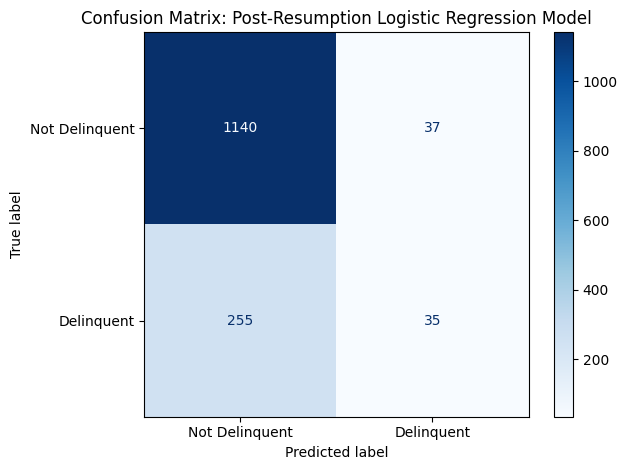

Classification Report (Post-Resumption Model):
                precision    recall  f1-score   support

Not Delinquent       0.82      0.97      0.89      1177
    Delinquent       0.49      0.12      0.19       290

      accuracy                           0.80      1467
     macro avg       0.65      0.54      0.54      1467
  weighted avg       0.75      0.80      0.75      1467



In [26]:
# Predict labels for post-resumption test data
y_post_pred = model_post.predict(X_post)

# Generate and display confusion matrix
cm = confusion_matrix(y_post, y_post_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Delinquent", "Delinquent"])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix: Post-Resumption Logistic Regression Model')
plt.tight_layout()
plt.show()

# Print classification report with updated metrics
print("Classification Report (Post-Resumption Model):")
print(classification_report(y_post, y_post_pred, target_names=["Not Delinquent", "Delinquent"]))